# Sentimen Analis Data Berita
### Library yang digunakan : pandas, re, transforfer,tdqm, matplotlib, wordcloud, collections

In [28]:
import pandas as pd
import re

# Memuat data
data = pd.read_csv('data.csv')

# Menampilkan beberapa baris pertama dan terakhir sebelum pemrosesan
print("Data Sebelum Pemrosesan:")
print(data[['Content', 'Link']].head())  # Menampilkan 5 baris pertama
print("\nData Terakhir Sebelum Pemrosesan:")
print(data[['Content', 'Link']].tail())  # Menampilkan 5 baris terakhir

# Menghapus baris di mana 'Content' berisi "Isi artikel tidak ditemukan"
data = data[data['Content'] != "Isi artikel tidak ditemukan"]

# Menghapus baris dengan nilai 'Link' yang duplikat
data = data.drop_duplicates(subset='Link')

# Menghapus jumlah kata yang berbeda di 'Content' berdasarkan 'Source' 
# untuk menghilangkan kata-kata template dari masing-masing portal berita
def remove_words(content, source):
    if source == "IDN Times":
        return ' '.join(content.split()[3:])
    elif source in ["Liputan 6", "Tribunnews.com", "KOMPAS TV"]:
        return ' '.join(content.split()[2:])
    elif source == "Detik News":
        return ' '.join(content.split()[1:])
    else:
        return content

data['Content'] = data.apply(lambda row: remove_words(row['Content'], row['Source']), axis=1)

# Mengubah semua teks di 'Content' menjadi huruf kecil
data['Content'] = data['Content'].str.lower()

# Menghapus simbol dari 'Content'
data['Content'] = data['Content'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# Menampilkan beberapa baris pertama dan terakhir setelah pemrosesan
print("\nData Setelah Pemrosesan:")
print(data[['Content', 'Link']].head())  # Menampilkan 5 baris pertama
print("\nData Terakhir Setelah Pemrosesan:")
print(data[['Content', 'Link']].tail())  # Menampilkan 5 baris terakhir


Data Sebelum Pemrosesan:
                                             Content  \
0  Jakarta, IDN Times- Luluk Nur Humaidah bertaru...   
1  Jakarta, IDN Times- Bakal Calon Gubernur Jawa ...   
2  Jakarta, IDN Times- Bakal Calon Gubernur Jawa ...   
3  Jakarta, IDN Times- Provinsi Jawa Timur menjad...   
4  Jakarta, IDN Times- Menteri Sosial (Mensos) RI...   

                                                Link  
0  https://www.idntimes.com/news/indonesia/jorot-...  
1  https://www.idntimes.com/news/indonesia/amir-f...  
2  https://www.idntimes.com/news/indonesia/amir-f...  
3  https://www.idntimes.com/news/indonesia/margit...  
4  https://www.idntimes.com/news/indonesia/amir-f...  

Data Terakhir Sebelum Pemrosesan:
                                                 Content  \
40131  Pendaftaran calon Pilkada 2024 dibuka hari ini...   
40132  PDIP telah menetapkan 8 Paslon untuk bersaing ...   
40133  Kepolisian Resor Kota (Polresta) Mataram melar...   
40134  Anies Baswedan batal maju 

In [13]:
from transformers import pipeline
from tqdm import tqdm

# Memuat pipeline analisis sentimen
sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    return_all_scores=True,
    truncation=True,
    max_length=512,
    batch_size=8
)

# Mengklasifikasikan sentimen dari setiap konten dengan progress bar
sentiment_results = []
for result in tqdm(sentiment_classifier(data['Content'].tolist(), batch_size=8), desc="Proses Analisis Sentimen"):
    sentiment_results.append(result)

# Mengambil label dengan skor tertinggi untuk setiap hasil
sentiments = []
scores = []
for result in sentiment_results:
    sorted_result = sorted(result, key=lambda x: x['score'], reverse=True)
    sentiments.append(sorted_result[0]['label'])
    scores.append(sorted_result[0]['score'])

# Menambahkan hasil analisis sentimen ke DataFrame
data['Sentiment'] = sentiments
data['Score'] = scores


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/home/widya-analytic/anaconda3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Proses Analisis Sentimen: 100%|██████████| 40136/40136 [00:00<00:00, 2473298.44it/s]


In [24]:
#menyimpan dataframe hasil sentimen analis kedalam csv
data.to_csv('hasil_sentimen.csv', index=False)

/tmp/ipykernel_5129/2940583540.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x='Sentiment', data=data, palette='viridis')


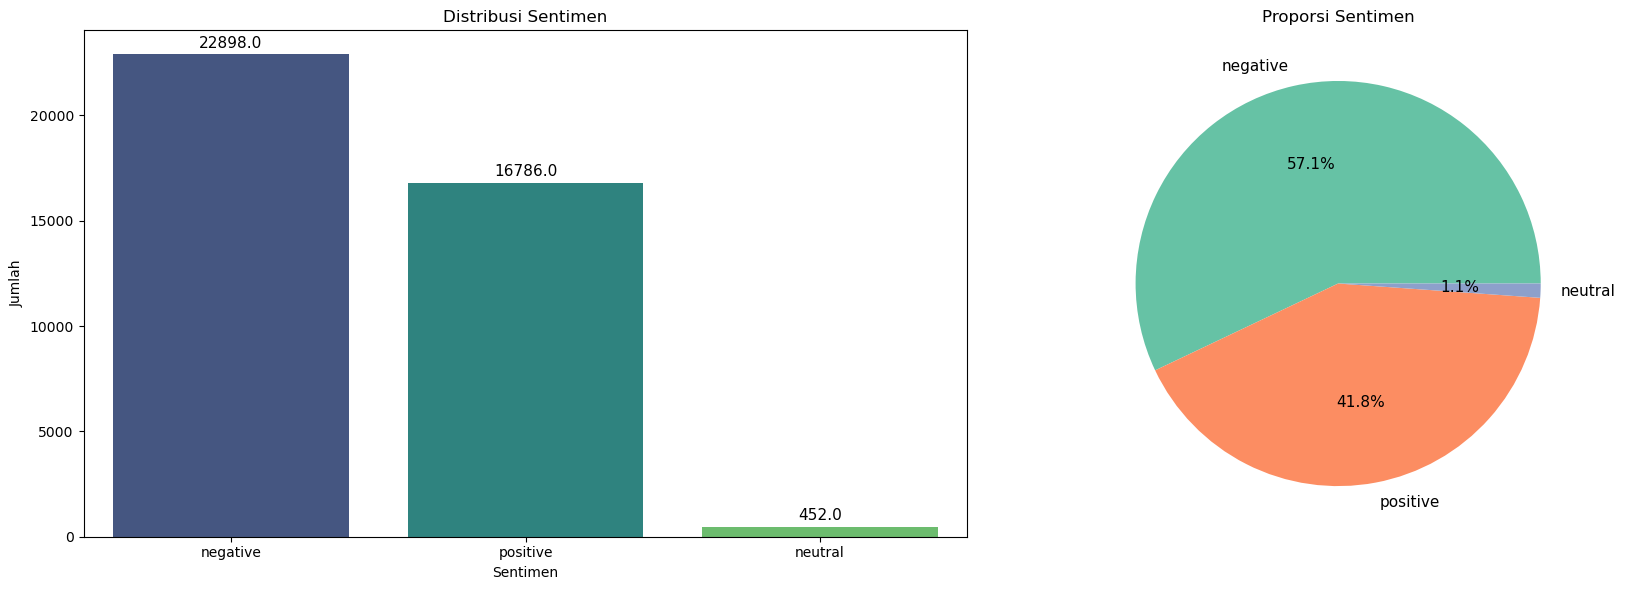

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('hasil_sentimen.csv')

# Menghitung jumlah sentimen untuk digunakan dalam pie chart
sentiment_counts = data['Sentiment'].value_counts()

# Membuat figure dengan dua subplots: satu untuk bar chart dan satu lagi untuk pie chart
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart untuk distribusi sentimen
sns.countplot(ax=axes[0], x='Sentiment', data=data, palette='viridis')
axes[0].set_title('Distribusi Sentimen')
axes[0].set_xlabel('Sentimen')
axes[0].set_ylabel('Jumlah')

# Menambahkan label pada masing-masing bar di bar chart
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5), 
                     textcoords='offset points')

# Pie chart untuk distribusi sentimen 
colors = sns.color_palette('Set2')  # Menggunakan palet warna yang lebih cerah dan kontras
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, textprops={'color': 'black', 'fontsize': 11})
axes[1].set_title('Proporsi Sentimen')

# Menampilkan figure
plt.tight_layout()
plt.show()


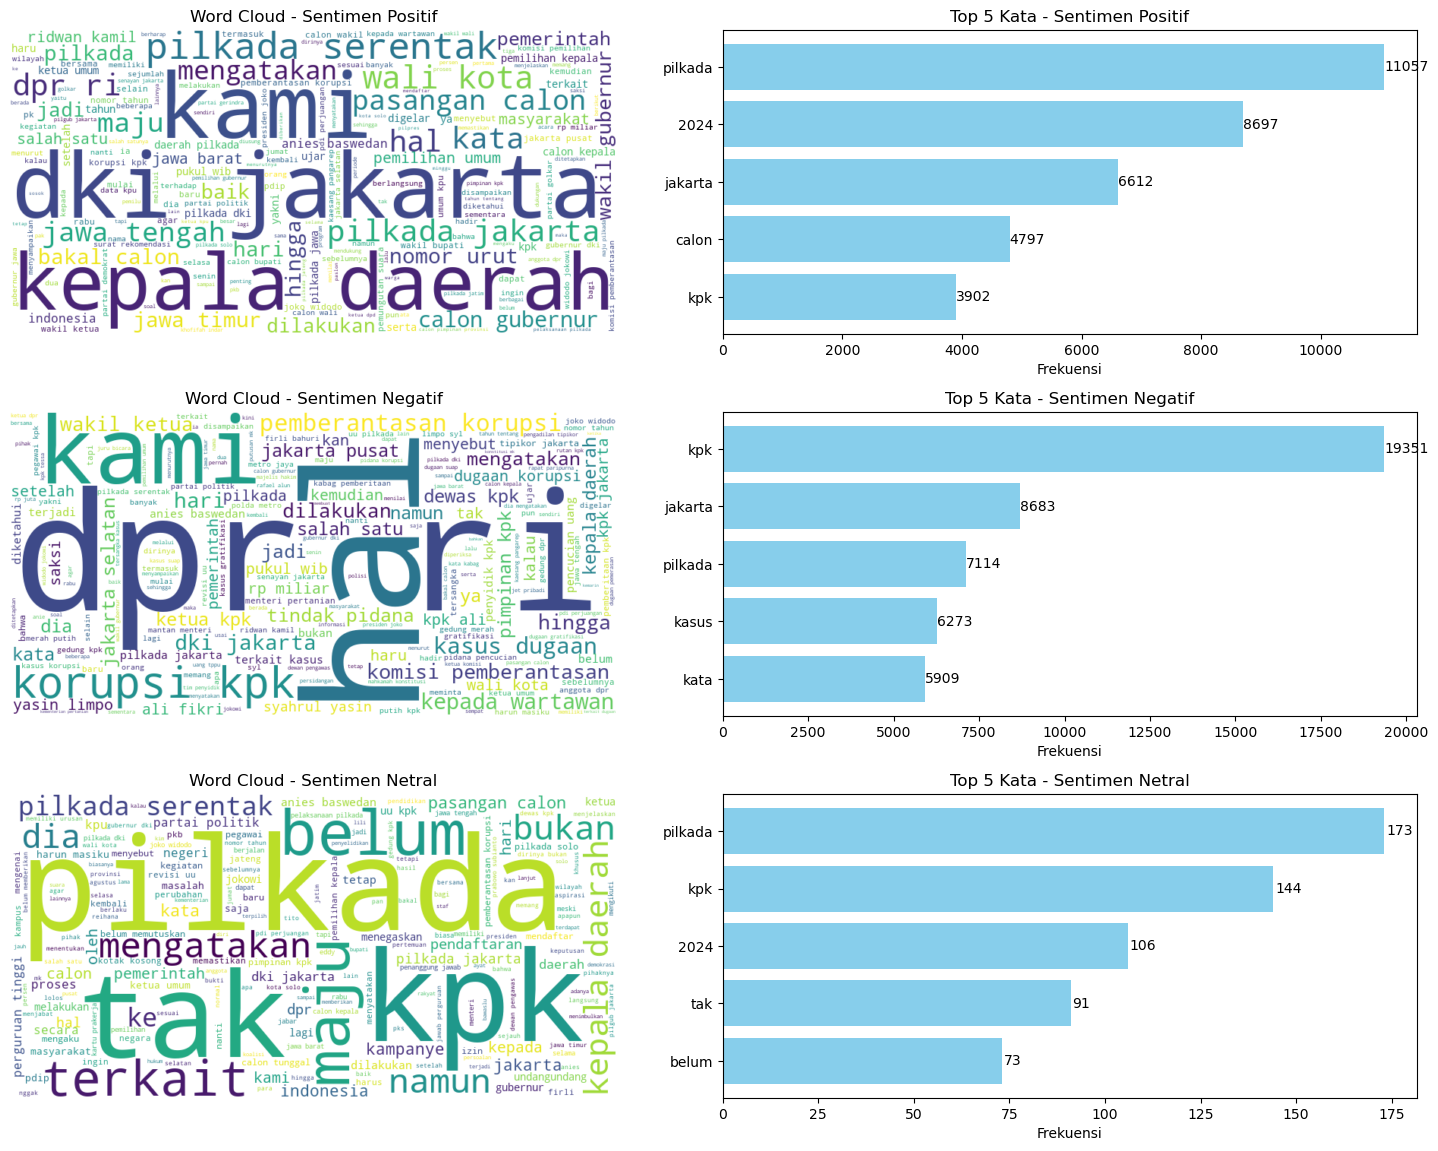

In [30]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter
import re

# Mendefinisikan daftar stopwords yang lebih komprehensif
custom_stopwords = set(STOPWORDS).union({
    "saya", "ini", "dan", "yang", "untuk", "dari", "pada", "atau", "adalah", 
    "tidak", "itu", "dengan", "sebagai", "mereka", "juga", "lebih", "semua", 
    "akan", "telah", "misalnya", "tersebut", "seperti", "karena", "begitu", 
    "hanya", "saat", "mengapa", "apakah", "kita", "maupun", "merupakan",
    "itu", "sebuah", "bisa", "sangat", "paling", "kurang", "saat", 
    "yang", "menjadi", "kita", "jika", "masih", "semua", "sudah", 
    "jika", "di", "baca", "juga", "dalam", "ada", "halaman",
    "advertisement", "content", "continue", "scroll",
})

# Gabungkan semua konten berdasarkan sentimen dan pastikan semuanya menjadi lowercase
positive_text = ' '.join(data[data['Sentiment'] == 'positive']['Content']).lower()
neutral_text = ' '.join(data[data['Sentiment'] == 'neutral']['Content']).lower()
negative_text = ' '.join(data[data['Sentiment'] == 'negative']['Content']).lower()

# Hilangkan simbol dan whitespace ekstra (tetapi biarkan angka)
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # Hilangkan simbol kecuali angka
    text = re.sub(r'\s+', ' ', text).strip()  # Hilangkan whitespace ekstra
    return text

# Bersihkan teks untuk setiap kategori sentimen
positive_text = clean_text(positive_text)
neutral_text = clean_text(neutral_text)
negative_text = clean_text(negative_text)

# Hitung frekuensi kata untuk masing-masing sentimen
def get_top_n_words(text, n=5):
    # Tokenisasi dan hapus stopwords
    words = [word for word in text.split() if word not in custom_stopwords]
    return Counter(words).most_common(n)

# Dapatkan 5 kata teratas untuk setiap kategori sentimen
top_positive_words = get_top_n_words(positive_text, 5)
top_neutral_words = get_top_n_words(neutral_text, 5)
top_negative_words = get_top_n_words(negative_text, 5)

# Buat WordCloud untuk masing-masing sentimen
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', 
                                stopwords=custom_stopwords, 
                                relative_scaling=0.5).generate(positive_text)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white', 
                               stopwords=custom_stopwords, 
                               relative_scaling=0.5).generate(neutral_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', 
                                stopwords=custom_stopwords, 
                                relative_scaling=0.5).generate(negative_text)

# Visualisasi top 5 kata yang paling sering muncul untuk masing-masing sentimen
def plot_top_words(top_words, title, subplot_position):
    words, counts = zip(*top_words)  # Pisahkan kata dan frekuensi
    plt.subplot(4, 2, subplot_position)  # Buat subplot
    bars = plt.barh(words, counts, color='skyblue')  # Buat grafik batang horizontal
    plt.xlabel('Frekuensi')  # Label sumbu x
    plt.title(title)  # Judul grafik
    plt.gca().invert_yaxis()  # Membalik sumbu y agar urutan kata dari atas ke bawah

    # Menambahkan label jumlah pada setiap bar
    for bar, count in zip(bars, counts):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                 str(count), va='center', ha='left', fontsize=10, color='black')

plt.figure(figsize=(15, 15))

# WordCloud untuk sentimen positif
plt.subplot(4, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')  # Tampilkan WordCloud
plt.axis('off')  # Matikan sumbu
plt.title('Word Cloud - Sentimen Positif')  # Judul untuk WordCloud positif

# Top 5 kata untuk sentimen positif
plot_top_words(top_positive_words, 'Top 5 Kata - Sentimen Positif', 2)

# WordCloud untuk sentimen negatif
plt.subplot(4, 2, 3)
plt.imshow(wordcloud_negative, interpolation='bilinear')  # Tampilkan WordCloud
plt.axis('off')  # Matikan sumbu
plt.title('Word Cloud - Sentimen Negatif')  # Judul untuk WordCloud negatif

# Top 5 kata untuk sentimen negatif
plot_top_words(top_negative_words, 'Top 5 Kata - Sentimen Negatif', 4)

# WordCloud untuk sentimen netral
plt.subplot(4, 2, 5)
plt.imshow(wordcloud_neutral, interpolation='bilinear')  # Tampilkan WordCloud
plt.axis('off')  # Matikan sumbu
plt.title('Word Cloud - Sentimen Netral')  # Judul untuk WordCloud netral

# Top 5 kata untuk sentimen netral
plot_top_words(top_neutral_words, 'Top 5 Kata - Sentimen Netral', 6)

plt.tight_layout()  # Atur layout agar tidak bertumpuk
plt.show()  # Tampilkan semua visualisasi
